<div style="font-size:37px; font-weight:bold; line-height:1.1">
    Computer-aided exploration of the Martian geology
</div>

<p style="color:rgb(90,90,90);">
The MIT License (MIT)
<br>
Copyright (c) 2018 Massachusetts Institute of Technology
</p>
<p style="color:rgb(90,90,90);">
Author: Guillaume Rongier
<br>
We acknowledge support from NSF ACI1442997 (PI: V. Pankratius) and NASA AISTNNX15AG84G (PI: V. Pankratius).
</p>
<p style="color:rgb(90,90,90);">
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:
</p>
<ul style="color:rgb(90,90,90);">
<li>The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.</li>
<li>THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</li>
</ul>

This notebook is part of a set of notebooks to compute a favorability map for the selection of landing sites on Mars. A favorable site depends on two main constraints:
* Landing constraints which ensure that the system can land on a given area.
* Scientific targets which must be visited by a rover after landing, if the rover can drive to them.

The notebooks determine this favorability for a rover similar to NASA's Mars 2020 rover at 20 pixels per degree (3 km per pixel at the equator), and investigate our ability to explore Mars with enhanced landing and roving capabilities.

# Analysis of the favorability maps and traverse paths

Out goal here is to analyze both the favorability maps and the traverse paths to study the distribution of favorable areas and targets.

## Package imports

Load some functions for data import, data visualization, and favorability computation.

In [1]:
%matplotlib notebook

from skdiscovery.utilities.planetary.raster_management import *
from skdiscovery.utilities.planetary.vector_management import get_latitude_longitude_from_csv_file, add_path_to_map
from skdiscovery.utilities.planetary.geographical_computation import compute_longitude_and_latitude_maps
from skdiscovery.utilities.planetary.traverse_emulation import read_paths_from_csv_file
from skdiscovery.utilities.planetary.ellipse_uncertainty import *
from skdiscovery.utilities.planetary.fuzzy_logic import *

import matplotlib.pyplot as plt

from skimage import measure
from collections import Counter
from scipy import ndimage

## Setting

Geographical setting for the rasters.

In [2]:
mars_radius = 3389500. # meters

master_lon_min = -180.
master_lon_max = 180.
master_lat_min = -90.
master_lat_max = 90.
master_extent = (master_lon_min, master_lon_max, master_lat_min, master_lat_max)

master_width = 7200
master_height = 3600
master_geotransform = define_geotransform(master_lon_min, master_lon_max, 
                                          master_lat_min, master_lat_max, 
                                          master_width, master_height)
master_projection = '''PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0]]'''

master_spatial_reference_system = osr.SpatialReference(wkt = master_projection)
master_central_meridian = 0.

Folder structure from the base folder *CaseStudyMars_Data*:
<pre>
Base folder:   CaseStudyMars_Data/
               ├── Original_Data/
               │   ├── Interpreted_Data/
               │   ├── MEX/
               │   │   ├── HRSC/
               │   │   └── OMEGA/
               │   ├── MGS/
               │   │   ├── MOLA/
               │   │   └── TES/
               │   ├── MRO/
               │   │   ├── CRISM/
               │   │   └── HiRISE/
Output folder: └── Raster_Data_20ppd/
</pre>

In [3]:
base_folder = '/data/Mars/CaseStudyMars_Data/'
output_folder = 'Raster_Data_20ppd/'

Before running the notebook, make sure the file *Reference_Landing_Sites.csv* is in *CaseStudyMars_Data/Original_Data/*. This file is provided with the notebooks.

## Surface area favorable to landing

We want to see the proportion of Mars favorable for landing from the landing favorability map.

In [4]:
constraint_type = 'Landing'
ellipse_size = '25'

raster_name_affix = constraint_type
if ellipse_size != "":
    raster_name_affix += "_" + ellipse_size
print(raster_name_affix)

Landing_25


In [5]:
raster_favorability_landing = open_raster(base_folder + output_folder + 'Results_Favorability_' + raster_name_affix + '.tif')
print_raster_info(raster_favorability_landing)
raster_favorability_landing_array = get_raster_array(raster_favorability_landing)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


We compute the surface area for each cell of the map.

In [6]:
longitude_array, latitude_array = compute_longitude_and_latitude_maps(master_lon_min, master_lon_max, 
                                                                      master_lat_min, master_lat_max, 
                                                                      master_width, master_height)

In [7]:
surface_area_array = compute_surface_area(longitude_array, 
                                          latitude_array, 
                                          master_lon_min, master_lon_max, 
                                          master_lat_min, master_lat_max,
                                          mars_radius)

We get the surface area of the favorable areas for landing. Here, we deem an area favorable if its landing favorability is strictly higher than 0. It means that unfavorable areas are not considered, but poorly favorable areas with a favorability close to 0 are considered.

In [8]:
filtered_favorability_landing_array = np.copy(raster_favorability_landing_array)
filtered_favorability_landing_array[filtered_favorability_landing_array > 0] = 1
filtered_favorability_landing_array *= surface_area_array

<IPython.core.display.Javascript object>


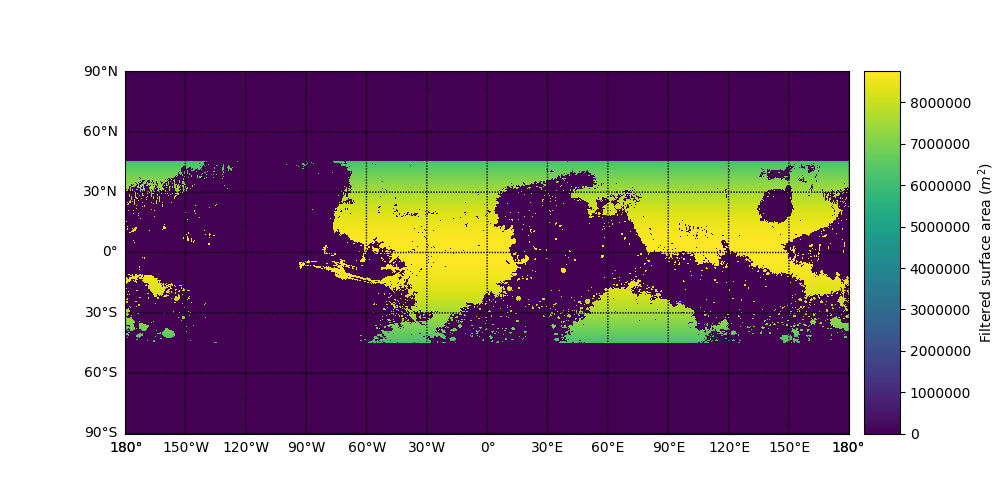

In [9]:
figure = plt.figure(figsize = (10, 5))
subfigure1 = figure.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)
add_raster_to_map(basemap1, filtered_favorability_landing_array, 'Filtered surface area ($m^2$)')
basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

In [10]:
print('Surface area of Mars:', np.sum(surface_area_array), 'm\u00b2')
print('Surface area favorable for landing:', np.sum(filtered_favorability_landing_array), 'm\u00b2')
print('Proportion of Mars favorable for landing', np.sum(filtered_favorability_landing_array)/np.sum(surface_area_array))

Surface area of Mars: 1.44371390883e+14 m²
Surface area favorable for landing: 4.18663224149e+13 m²
Proportion of Mars favorable for landing 0.289990434801


## Analysis of the traverse paths

Now our goal is it look at the best traverse paths in detail. Although they must miss many potential targets, they can still provide some insight about what we can visit.

First, we need the traverse paths from the four exploration scenarios.

In [11]:
path_files = ['Results_List_Paths_StandingWater_EarlyMiddleNoachian_25.csv',
              'Results_List_Paths_StandingWater_HesperianNoachian_25.csv',
              'Results_List_Paths_GroundWater_AllTime_25.csv', 
              'Results_List_Paths_WaterMagma_AllTime_25.csv']

scenario_names = ['Past standing-water on Early to Middle Noachian units',
                  'Past standing-water near the Noachian-Hesperian boundary',
                  'Past groundwater',
                  'Past water-magma associations']

In [12]:
path_dicts = []

for file in path_files:
    path_dicts.append(read_paths_from_csv_file(base_folder + output_folder + file))

Then, we count how many targets appear in the paths.

In [13]:
for path_dict, scenario_name in zip(path_dicts, scenario_names):

    targets_all_paths = []
    initial_landing_favorability_all_paths = []
    path_lengths_all_paths = []
    threshold_lengths_all_paths = []
    number_of_neighbors_all_paths = []

    for path in path_dict:
        targets_all_paths += [node[0][3] for node in path]
        initial_landing_favorability_all_paths.append(raster_favorability_landing_array[path[0][0][0]])
        path_lengths_all_paths.append(path[-1][1])
        threshold_lengths_all_paths.append(path_dict.get(path)[1])
        number_of_neighbors_all_paths.append(len(path))

    target_count_all_paths = Counter(targets_all_paths)
    target_count_all_paths = [(target_count_all_paths[key], key) for key in target_count_all_paths]
    target_count_all_paths.sort(reverse = True)

    print('~'*80)
    print(scenario_name)
    print('Number of paths:', len(path_dict))
    print('Number of targets per path [mean(min, max)]: ', np.mean(number_of_neighbors_all_paths), ' (', np.min(number_of_neighbors_all_paths), ', ', np.max(number_of_neighbors_all_paths), ')', sep = '')
    print('Traverse time (sols) [mean(min, max)]: ', np.mean(path_lengths_all_paths), ' (', np.min(path_lengths_all_paths), ', ', np.max(path_lengths_all_paths), ')', sep = '')
    print('Threshold time (sols) [mean(min, max)]: ', np.mean(threshold_lengths_all_paths), ' (', np.min(threshold_lengths_all_paths), ', ', np.max(threshold_lengths_all_paths), ')', sep = '')
    print('Landing favorability [mean(min, max)]: ', np.mean(initial_landing_favorability_all_paths), ' (', np.min(initial_landing_favorability_all_paths), ', ', np.max(initial_landing_favorability_all_paths), ')\n', sep = '')
    for target in target_count_all_paths:
        print(target)

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Past standing-water on Early to Middle Noachian units
Number of paths: 2151
Number of targets per path [mean(min, max)]: 7.63923756392 (3, 22)
Traverse time (sols) [mean(min, max)]: 21.1715078228 (2.66551494903, 24.996927527)
Threshold time (sols) [mean(min, max)]: 19.2942707605 (0.0, 24.996927527)
Landing favorability [mean(min, max)]: 0.32171847375 (0.0, 0.99076714759)

(6310, 'Early to Middle Noa. units')
(2716, 'Polygonal-ridge networks')
(1902, 'Sedimentary-rock exposures')
(1872, 'Hydrous-mineral exposures')
(1406, 'Valley networks')
(449, 'Large degraded craters')
(423, 'Chloride exposures')
(271, 'Open-basin lakes')
(153, 'Crater-wall channels')
(130, 'Crater-floor valley deposits')
(124, 'Outflow channels')
(90, 'Graben axes')
(89, 'Deltaic deposits')
(85, 'Young deltas')
(62, 'Closed-basin lakes')
(58, 'Hes. to Am. volcanic units')
(43, 'Wrinkle ridges')
(43, 'Crater-floor channels')
(36, 'Glacia

## Favorability for some existing and proposed landing sites

Now we want to find the favorability of some existing and proposed landing sites, to look how the favorability performs with sites usually considered relevant. The proposed sites come from [Grant et al. [2011]](http://doi.org/10.1016/j.pss.2010.06.016) and [E2E-iSAG [2012]](http://doi.org/10.1089/ast.2011.0805).

In [14]:
reference_landing_sites = get_latitude_longitude_from_csv_file(base_folder + 'Original_Data/Reference_Landing_Sites.csv',
                                                               longitude_column_index = 0, 
                                                               latitude_column_index = 1,
                                                               other_data_column_indexes = [2, 3])

In [15]:
proposed_landing_sites = list(zip(*list(zip(*reference_landing_sites))[4:]))

We choose the method to select the scientific targets of interest, either based on the threshold targets or on the best traverse paths; and we define the landing ellipse.

In [16]:
# selection_method = 'Threshold'
selection_method = 'Paths'

In [17]:
a = 12500. # meters
b = 10000. # meters
azimuth = 90*np.pi/180

number_of_nodes = 500

rad_longitude_array = longitude_array*np.pi/180.
rad_latitude_array = latitude_array*np.pi/180.

We get the scientific and selection favorability maps made with the selected method.

In [18]:
constraint_type = 'Scientific_' + selection_method + '_4_Scenarios_25'
ellipse_size = '25'

raster_name_affix = constraint_type
if ellipse_size != "":
    raster_name_affix += "_" + ellipse_size
print(raster_name_affix)

Scientific_Paths_4_Scenarios_25_25


In [19]:
raster_favorability_scientific = open_raster(base_folder + output_folder + 'Results_Favorability_' + raster_name_affix + '.tif')
print_raster_info(raster_favorability_scientific)
raster_favorability_scientific_array = get_raster_array(raster_favorability_scientific)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


In [20]:
constraint_type = 'Selection_' + selection_method + '_4_Scenarios_25'
ellipse_size = '25'

raster_name_affix = constraint_type
if ellipse_size != "":
    raster_name_affix += "_" + ellipse_size
print(raster_name_affix)

Selection_Paths_4_Scenarios_25_25


In [21]:
raster_favorability_selection = open_raster(base_folder + output_folder + 'Results_Favorability_' + raster_name_affix + '.tif')
print_raster_info(raster_favorability_selection)
raster_favorability_selection_array = get_raster_array(raster_favorability_selection)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


We plot the proposed landing sites.

<IPython.core.display.Javascript object>


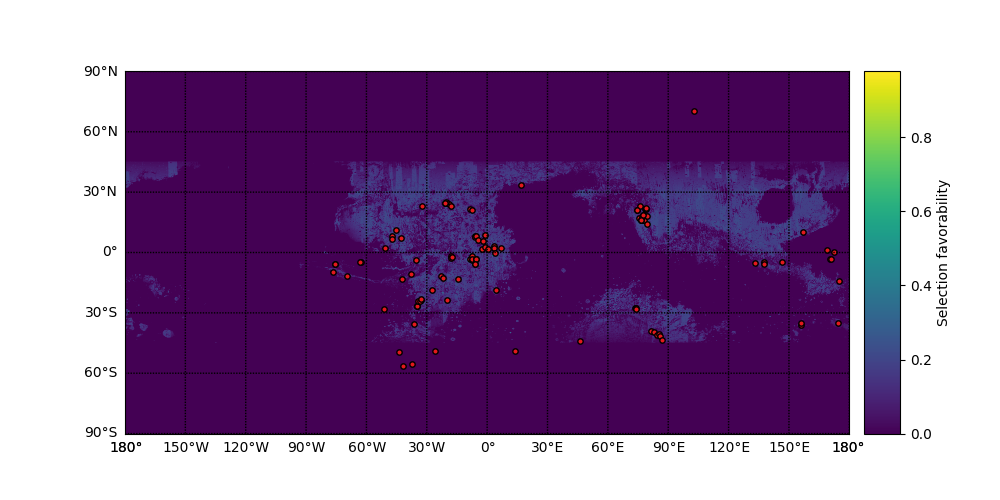

In [22]:
figure = plt.figure(figsize = (10, 5))
subfigure1 = figure.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)

add_raster_to_map(basemap1, raster_favorability_selection_array, 'Selection favorability')

plt.scatter(proposed_landing_sites[0], 
            proposed_landing_sites[1], 
            color = '#e31a1c',
            s = 15,
            edgecolor='black',
            zorder = 2)

basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

We can also compare the distribution of proposed landing sites with the distribution of the traverse paths, showing their initial targets depending on the exploration scenario:
* Past standing-water on Early to Middle Noachian units: blue square
* Past standing-water near the Noachian-Hesperian boundary: orange circle
* Past groundwater: green triangle
* Past water-magma associations: red reversed triangle

In [23]:
target_scenarios = [[[], []] for scenario in scenario_names]

for scenario, scenario_name in enumerate(scenario_names):
    
    print(scenario_name)
    
    for path in path_dicts[scenario]:
        target_scenarios[scenario][0].append(longitude_array[path[0][0][0]])
        target_scenarios[scenario][1].append(latitude_array[path[0][0][0]])

Past standing-water on Early to Middle Noachian units
Past standing-water near the Noachian-Hesperian boundary
Past groundwater
Past water-magma associations


<IPython.core.display.Javascript object>


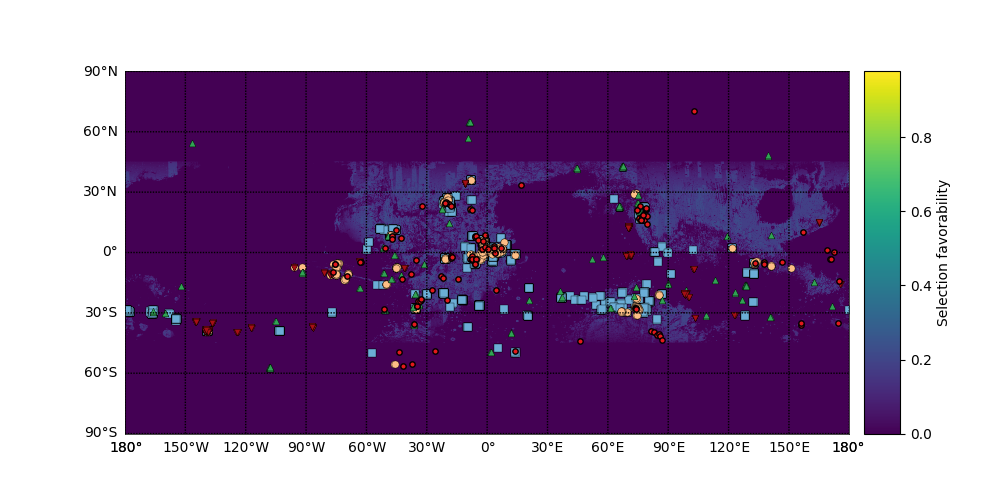

In [24]:
figure = plt.figure(figsize = (10, 5))
subfigure1 = figure.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)

add_raster_to_map(basemap1, raster_favorability_selection_array, 'Selection favorability')

legend_colors = ['#6baed6', '#fdbe85','#31a354','#a50f15']
legend_markers = ['s','o','^','v']
legend_sizes = np.linspace(30, 20, 4)
for i in range(len(scenario_names)):
    plt.scatter(target_scenarios[i][0], 
                target_scenarios[i][1], 
                color = legend_colors[i],
                marker = legend_markers[i],
                s = legend_sizes[i],
                edgecolor='black',
                linewidth = 0.25,
                zorder = 2)

plt.scatter(proposed_landing_sites[0], 
            proposed_landing_sites[1], 
            color = '#e31a1c',
            s = 15,
            edgecolor='black',
            zorder = 2)

basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

We get the landing, scientific and selection favorability at the landing sites.

In [25]:
reference_landing_sites_favorability_landing = []
reference_landing_sites_favorability_scientific = []
reference_landing_sites_favorability_selection = []
for landing_site_longitude, landing_site_latitude in zip(proposed_landing_sites[0], 
                                                         proposed_landing_sites[1]):
    landing_site_i, landing_site_j = transform_to_pixel_coordinates(landing_site_longitude, 
                                                                    landing_site_latitude, 
                                                                    master_lon_min, 
                                                                    master_lon_max, 
                                                                    master_lat_min, 
                                                                    master_lat_max, 
                                                                    master_width, 
                                                                    master_height)
    reference_landing_sites_favorability_landing.append(raster_favorability_landing_array[int(landing_site_j), 
                                                                                          int(landing_site_i)])
    reference_landing_sites_favorability_scientific.append(raster_favorability_scientific_array[int(landing_site_j), 
                                                                                                int(landing_site_i)])
    reference_landing_sites_favorability_selection.append(raster_favorability_selection_array[int(landing_site_j), 
                                                                                              int(landing_site_i)])

Now, for each proposed landing site, we look for the location with the highest selection favorability inside the landing ellipse.

In [26]:
better_references_locations = [[], [], [], [], [], [], [], [], []]

for lon, lat, label, old_scien_fav, old_land_fav, old_selec_fav in zip(proposed_landing_sites[0], proposed_landing_sites[1], proposed_landing_sites[2],
                           reference_landing_sites_favorability_scientific,
                           reference_landing_sites_favorability_landing,
                           reference_landing_sites_favorability_selection):

    rad_center_longitude = lon*np.pi/180.
    rad_center_latitude = lat*np.pi/180.

    number_of_nodes = compute_number_of_ellipse_nodes(lat)

    slice_1_i, slice_1_j, \
    slice_2_i, slice_2_j = compute_ellipse_path_and_bounding_box(lon,
                                                                 lat, 
                                                                 a,
                                                                 b,
                                                                 azimuth, 
                                                                 master_lon_min,
                                                                 master_lon_max, 
                                                                 master_lat_min,
                                                                 master_lat_max, 
                                                                 master_width,
                                                                 master_height, 
                                                                 mars_radius,
                                                                 number_of_nodes = number_of_nodes)

    ellipse_slice_1 = np.index_exp[slice_1_j[0]:slice_1_j[1], slice_1_i[0]:slice_1_i[1]]
    ellipse_slice_2 = np.index_exp[slice_2_j[0]:slice_2_j[1], slice_2_i[0]:slice_2_i[1]]

    center_distances_1 = compute_raster_ellipse(raster_favorability_selection_array, 
                                               rad_center_longitude, rad_center_latitude, 
                                               rad_longitude_array, rad_latitude_array,
                                               mars_radius,
                                               a, b, azimuth,
                                               ellipse_slice_1)
    center_distances_2 = compute_raster_ellipse(raster_favorability_selection_array, 
                                               rad_center_longitude, rad_center_latitude, 
                                               rad_longitude_array, rad_latitude_array,
                                               mars_radius,
                                               a, b, azimuth,
                                               ellipse_slice_2)
    center_distance_array = np.full((master_height, master_width), np.nan)
    center_distance_array[ellipse_slice_1] = center_distances_1
    center_distance_array[ellipse_slice_2] = center_distances_2
    max_favorability_index = np.nanargmax(center_distance_array)
    max_favorability_index = np.unravel_index(max_favorability_index, center_distance_array.shape)

    better_references_locations[0].append(lon)
    better_references_locations[1].append(lat)
    better_references_locations[2].append(label)
    better_references_locations[3].append(raster_favorability_landing_array[max_favorability_index])
    better_references_locations[4].append(raster_favorability_scientific_array[max_favorability_index])
    better_references_locations[5].append(raster_favorability_selection_array[max_favorability_index])
    better_references_locations[6].append(old_land_fav)
    better_references_locations[7].append(old_scien_fav)
    better_references_locations[8].append(old_selec_fav)

<IPython.core.display.Javascript object>


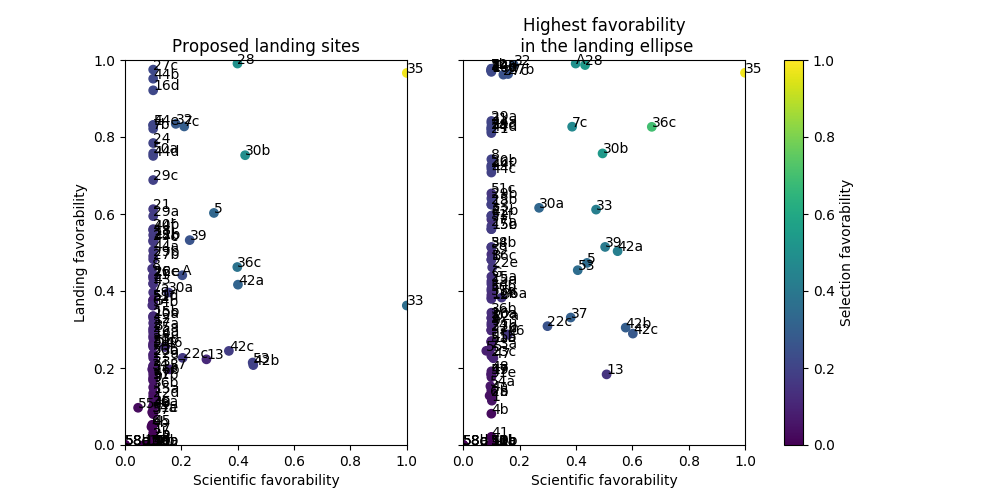

In [27]:
figure, (subplot1, subplot2) = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (10, 5))

scatter1 = subplot1.scatter(reference_landing_sites_favorability_scientific,
                            reference_landing_sites_favorability_landing,
                            c = reference_landing_sites_favorability_selection,
                            cmap = 'viridis',
                            vmin = 0.,
                            vmax = 1.)
for label, x, y in zip(proposed_landing_sites[2],
                       reference_landing_sites_favorability_scientific,
                       reference_landing_sites_favorability_landing):
    subplot1.annotate(label, xy = (x, y))
subplot1.set_title('Proposed landing sites')
subplot1.set_xlabel("Scientific favorability")
subplot1.set_ylabel("Landing favorability")
subplot1.set_xlim([0., 1.])
subplot1.set_ylim([0., 1.])

scatter2 = subplot2.scatter(better_references_locations[4],
                            better_references_locations[3],
                            c = better_references_locations[5],
                            cmap = 'viridis',
                            vmin = 0.,
                            vmax = 1.)
for label, x, y in zip(better_references_locations[2],
                       better_references_locations[4],
                       better_references_locations[3]):
    subplot2.annotate(label, xy = (x, y))
subplot2.set_title('Highest favorability\n in the landing ellipse')
subplot2.set_xlabel("Scientific favorability")
subplot2.set_xlim([0., 1.])
subplot2.set_ylim([0., 1.])

scatter_colorbar = figure.colorbar(scatter1, cmap = 'viridis', ax = [subplot1, subplot2])
scatter_colorbar.set_label('Selection favorability')

# Thin the axes lines ("spines")
subfigure1.spines['left'].set_linewidth(0.5)
subfigure1.spines['bottom'].set_linewidth(0.5)
subfigure1.spines['right'].set_linewidth(0.5)
subfigure1.spines['top'].set_linewidth(0.5)

plt.show()

## Landing sites from the selection favorability

We want to look for the sites suggested by selection favorability. Most values are below 0.2, and do not have any threshold target or initial target of a path nearby. On the other hand, areas with a favorability higher than 0.3 should have a threshold target or initial target of a path nearby. So, we focus on the areas with a favorability higher than 0.3, and we get the location with the highest selection favorability for each area.

<IPython.core.display.Javascript object>


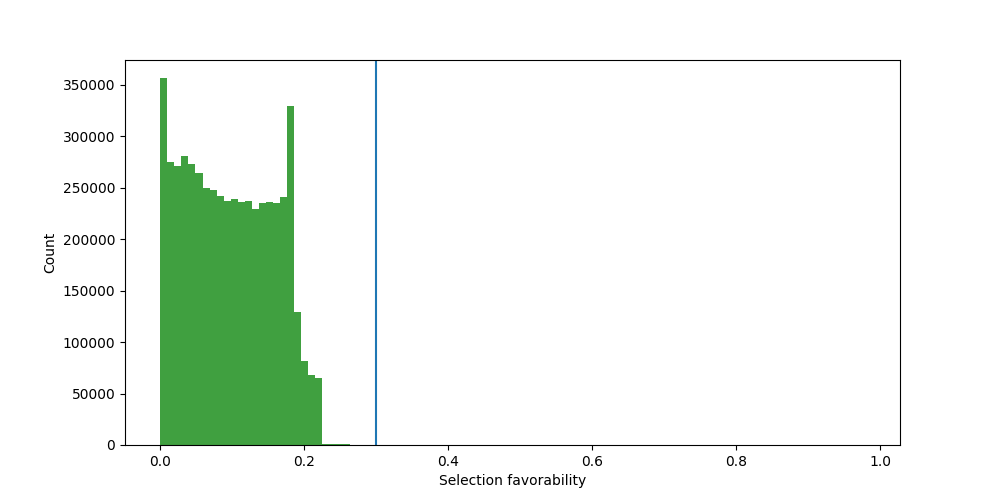

In [28]:
figure = plt.figure(figsize = (10, 5))

n, bins, patches = plt.hist(raster_favorability_selection_array[raster_favorability_selection_array > 0.].ravel(),
                            100, facecolor = 'green', alpha = 0.75)

plt.axvline(x = 0.3)

plt.xlabel("Selection favorability")
plt.ylabel("Count")

plt.show()

In [29]:
favorability_thresholds = [0.3]

highest_favorability_locations = []

index_array = np.indices(raster_favorability_selection_array.shape)
index_array = np.array(list(zip(index_array[0,:,:].ravel(),
                                index_array[1,:,:].ravel())),
                       dtype=('i4,i4')).reshape(index_array[0,:,:].shape)

for favorability_threshold in favorability_thresholds:
    fuzzified_favorability_array = trapezoidal_function(raster_favorability_selection_array,
                                                        favorability_threshold, favorability_threshold, 1, 1,
                                                        bottom_value = 0, plateau_value = 1, nan_value = 0)

    components_favorability_array = measure.label(fuzzified_favorability_array, background = 0)

    temp = [[], [], [], []]

    for value in np.unique(components_favorability_array):
        if value > 0 and len(raster_favorability_selection_array[components_favorability_array == value]) > 0:
            max_index = np.argmax(raster_favorability_selection_array[components_favorability_array == value])
            max_index = tuple(index_array[components_favorability_array == value][max_index])
            is_cell_already_added = False
            for locations in highest_favorability_locations:
                if max_index in locations[2]:
                    is_cell_already_added = True
            if is_cell_already_added == False:
                temp[0].append(longitude_array[max_index])
                temp[1].append(latitude_array[max_index])
                temp[2].append(max_index)
                temp[3].append(favorability_threshold)

    highest_favorability_locations.append(temp)
        
index_array = None

We map the selection favorability contoured at 0.3 with the proposed landing sites from the previous section and NASA's previous rovers (orange markers; Sojourner: reversed triangle; Opportunity: circle; Spirit: diamond; Curiosity: square).

<IPython.core.display.Javascript object>


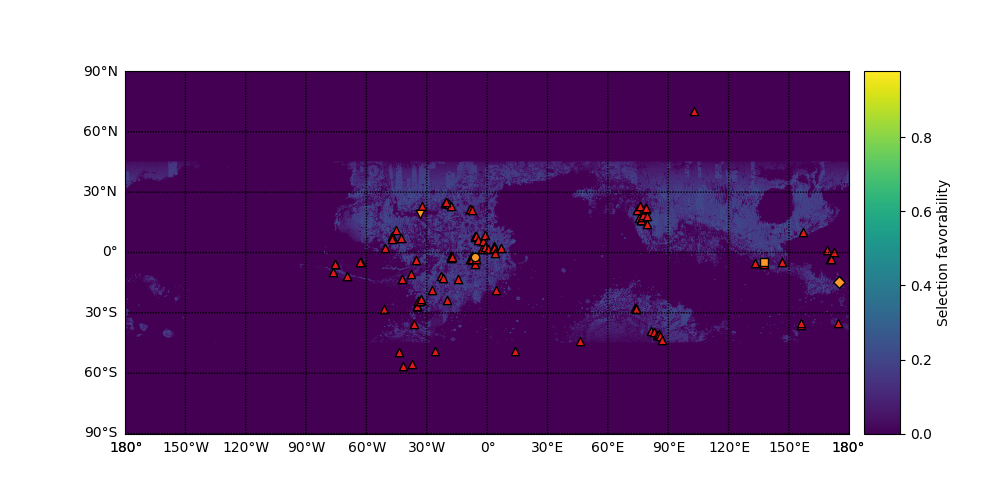

In [30]:
figure = plt.figure(figsize = (10, 5))
subfigure1 = figure.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)

add_raster_to_map(basemap1, raster_favorability_selection_array, 'Selection favorability')

# Smooth contour with Gaussian filter
contour = plt.contour(longitude_array,
                      latitude_array,
                      ndimage.gaussian_filter(raster_favorability_selection_array, sigma = 0.65, order = 0),
                      [0.3],
                      linewidths = 0.75,
                      colors = '#000000',
                      linestyles = 'dashed',
                      alpha = 0.5)

plt.scatter(reference_landing_sites[0][4:-7], 
            reference_landing_sites[1][4:-7], 
            color = '#e31a1c', 
            marker = '^',
            edgecolor='black',
            zorder = 2)
ref_legend_markers = ['v', 'D', 'o', 's']
for index, reference_landing_site in enumerate(list(zip(*reference_landing_sites))[:4]):
    plt.scatter(reference_landing_site[0], 
                reference_landing_site[1], 
                color = '#fe9929', 
                marker = ref_legend_markers[index],
                edgecolor='black',
                zorder = 2)

basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()

Get the locations of the selected targets for each exploration scenario.

In [31]:
rasters = []

if selection_method == 'Threshold':
    raster_locations_nh_standingwater = open_raster(base_folder + output_folder + 'Results_Locations_Threshold_StandingWater_HesperianNoachian_25.tif')
    raster_locations_nh_standingwater_array = get_raster_array(raster_locations_nh_standingwater)

    raster_locations_emn_standingwater = open_raster(base_folder + output_folder + 'Results_Locations_Threshold_StandingWater_EarlyMiddleNoachian_25.tif')
    raster_locations_emn_standingwater_array = get_raster_array(raster_locations_emn_standingwater)

    raster_locations_groundwater = open_raster(base_folder + output_folder + 'Results_Locations_Threshold_GroundWater_AllTime_25.tif')
    raster_locations_groundwater_array = get_raster_array(raster_locations_groundwater)

    raster_locations_magma = open_raster(base_folder + output_folder + 'Results_Locations_Threshold_WaterMagma_AllTime_25.tif')
    raster_locations_magma_array = get_raster_array(raster_locations_magma)

    rasters = [raster_locations_emn_standingwater_array,
               raster_locations_nh_standingwater_array,
               raster_locations_groundwater_array,
               raster_locations_magma_array]

elif selection_method == 'Paths':
    path_file = 'Results_List_Paths_StandingWater_EarlyMiddleNoachian_25.csv'
    paths_dict = read_paths_from_csv_file(base_folder + output_folder + path_file)
    raster_locations_emn_standingwater_array = np.ones((master_height, master_width))
    for path in paths_dict:
        raster_locations_emn_standingwater_array[path[0][0][0]] = 0

    path_file = 'Results_List_Paths_StandingWater_HesperianNoachian_25.csv'
    paths_dict = read_paths_from_csv_file(base_folder + output_folder + path_file)
    raster_locations_nh_standingwater_array = np.ones((master_height, master_width))
    for path in paths_dict:
        raster_locations_nh_standingwater_array[path[0][0][0]] = 0

    path_file = 'Results_List_Paths_GroundWater_AllTime_25.csv'
    paths_dict = read_paths_from_csv_file(base_folder + output_folder + path_file)
    raster_locations_groundwater_array = np.ones((master_height, master_width))
    for path in paths_dict:
        raster_locations_groundwater_array[path[0][0][0]] = 0

    path_file = 'Results_List_Paths_WaterMagma_AllTime_25.csv'
    paths_dict = read_paths_from_csv_file(base_folder + output_folder + path_file)
    raster_locations_magma_array = np.ones((master_height, master_width))
    for path in paths_dict:
        raster_locations_magma_array[path[0][0][0]] = 0

    rasters = [raster_locations_emn_standingwater_array,
               raster_locations_nh_standingwater_array,
               raster_locations_groundwater_array,
               raster_locations_magma_array]

else:
    print('Unknown method')

Compute a landing ellipse at the locations with the highest favorability in each area above 0.3, and get the closest threshold target or initial target of a traverse path for each scenario.

&#9888; It can take some time for the entire planet.

In [32]:
%%time

closest_scenario_locations = []

for locations in highest_favorability_locations:
    
    if locations != [[], [], [], []]:
    
        temp = [[], [], [], [], []]

        for highest_favorability_location in zip(*locations):

            initial_array = np.ones(raster_favorability_selection_array.shape)
            initial_array[highest_favorability_location[2]] = 0

            distance_array = np.full(raster_favorability_selection_array.shape, np.inf)

            rad_center_longitude = highest_favorability_location[0]*np.pi/180.
            rad_center_latitude = highest_favorability_location[1]*np.pi/180.

            number_of_nodes = compute_number_of_ellipse_nodes(highest_favorability_location[1])

            slice_1_i, slice_1_j, \
            slice_2_i, slice_2_j = compute_ellipse_path_and_bounding_box(highest_favorability_location[0],
                                                                         highest_favorability_location[1], 
                                                                         a,
                                                                         b,
                                                                         azimuth, 
                                                                         master_lon_min,
                                                                         master_lon_max, 
                                                                         master_lat_min,
                                                                         master_lat_max, 
                                                                         master_width,
                                                                         master_height, 
                                                                         mars_radius,
                                                                         number_of_nodes = number_of_nodes)

            ellipse_slice_1 = np.index_exp[slice_1_j[0]:slice_1_j[1], slice_1_i[0]:slice_1_i[1]]
            ellipse_slice_2 = np.index_exp[slice_2_j[0]:slice_2_j[1], slice_2_i[0]:slice_2_i[1]]

            center_distances_1, center_bearings_1 = compute_great_circle_distance_and_bearing(rad_center_longitude, 
                                                                                              rad_center_latitude, 
                                                                                              rad_longitude_array[ellipse_slice_1], 
                                                                                              rad_latitude_array[ellipse_slice_1], 
                                                                                              mars_radius)
            ellipse_radii_1 = np.sqrt(2)*a*b/(np.sqrt((b**2 - a**2)*np.cos(2*center_bearings_1 - 2*azimuth) + a**2 + b**2))
            distance_array[ellipse_slice_1] = center_distances_1
            center_distances_2, center_bearings_2 = compute_great_circle_distance_and_bearing(rad_center_longitude, 
                                                                                              rad_center_latitude, 
                                                                                              rad_longitude_array[ellipse_slice_2], 
                                                                                              rad_latitude_array[ellipse_slice_2], 
                                                                                              mars_radius)
            ellipse_radii_2 = np.sqrt(2)*a*b/(np.sqrt((b**2 - a**2)*np.cos(2*center_bearings_2 - 2*azimuth) + a**2 + b**2))
            distance_array[ellipse_slice_2] = center_distances_2

            index_array = np.indices(raster_favorability_selection_array.shape)
            index_array = np.array(list(zip(distance_array.ravel(),
                                            index_array[0,:,:].ravel(),
                                            index_array[1,:,:].ravel())),
                                   dtype=('f,i4,i4')).reshape(raster_favorability_selection_array.shape)

            for raster, scenario in zip(rasters, scenario_names):
                sorted_scenarios = sorted(index_array[raster == 0].tolist())
                if len(sorted_scenarios) > 0 and ~np.isinf(sorted_scenarios[0][0]):
                    temp[0].append(longitude_array[sorted_scenarios[0][1],
                                                   sorted_scenarios[0][2]])
                    temp[1].append(latitude_array[sorted_scenarios[0][1],
                                                  sorted_scenarios[0][2]])
                    temp[2].append(scenario)
                    temp[3].append(highest_favorability_location[2])
                    temp[4].append(raster_favorability_selection_array[highest_favorability_location[2]])

        closest_scenario_locations.append(temp)

CPU times: user 11min 6s, sys: 3min 3s, total: 14min 9s
Wall time: 14min 7s


We can look at the locations of the ellipses and the related scenarios, with the raw selection favorability as background.

In [33]:
raster_name_affix = 'Selection_' + selection_method + '_4_Scenarios_25'
print(raster_name_affix)

Selection_Paths_4_Scenarios_25


In [34]:
raster_rawfavorability_selection = open_raster(base_folder + output_folder + 'Results_RawFavorability_' + raster_name_affix + '.tif')
print_raster_info(raster_rawfavorability_selection)
raster_rawfavorability_selection_array = get_raster_array(raster_rawfavorability_selection)

Driver:  GTiff / GeoTIFF
Size of the cube is  7200 x 3600 x 1
Projection is  PROJCS["SimpleCylindrical Mars",GEOGCS["GCS_Mars",DATUM["D_Mars",SPHEROID["Mars",3396000,0]],PRIMEM["Reference_Meridian",0],UNIT["degree",0.0174532925199433]],PROJECTION["Equirectangular"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",0],PARAMETER["standard_parallel_1",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]]]
Origin = ( -180.0 , 90.0 )
Pixel Size = ( 0.05 , -0.05 )


<IPython.core.display.Javascript object>


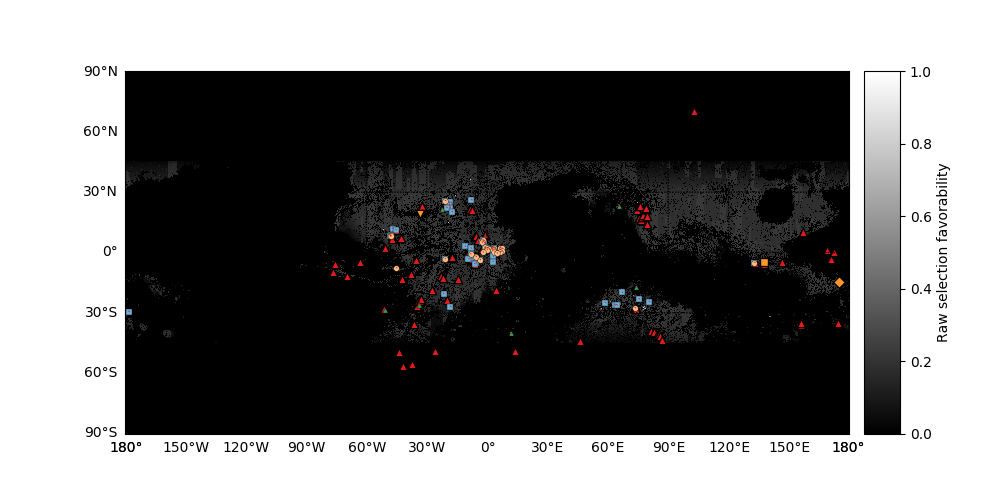

In [35]:
figure = plt.figure(figsize = (10, 5))
subfigure1 = figure.add_subplot(111)
basemap1 = Basemap(projection='cyl', resolution = None, lon_0 = 0, lat_0 = 0)

add_raster_to_map(basemap1, raster_rawfavorability_selection_array, 'Raw selection favorability', colormap = 'gray')

for locations in highest_favorability_locations:
    for longitude, latitude, coordinate, favorability in zip(*locations):
        ellipse_path_1, ellipse_path_2 = compute_ellipse_path(longitude, latitude, 
                                                          a, b, azimuth, 
                                                          mars_radius, 
                                                          number_of_nodes = number_of_nodes)
        add_path_to_map(subfigure1,
                        ellipse_path_1,
                        "Ellipse",
                        facecolor = 'None',
                        alpha = 1.,
                        edgecolor = '#e31a1c',
                        linewidth = 0.75,
                        linestyle = (0, (1, 1)),
                        zorder = 4)

scenario_colors = ['#6baed6', '#fdbe85','#31a354','#a50f15']
scenario_markers = ['s','o','^','v']
scenario_sizes = np.linspace(20, 10, 4)
for locations in closest_scenario_locations:
    for i in range(len(scenario_names)):
        scenario_locations = np.where(np.array(locations[2]) == scenario_names[i])
        if len(scenario_locations) > 0:
            plt.scatter(np.array(locations[0])[scenario_locations], 
                        np.array(locations[1])[scenario_locations], 
                        color = scenario_colors[i], 
                        marker = scenario_markers[i],
                        s = scenario_sizes[i],
                        edgecolor='black',
                        linewidth = 0.25,
                        zorder = 3)

plt.scatter(reference_landing_sites[0][4:-7], 
            reference_landing_sites[1][4:-7], 
            color = '#e31a1c', 
            marker = '^',
            edgecolor='black',
            zorder = 2)
ref_legend_markers = ['v', 'D', 'o', 's']
for index, reference_landing_site in enumerate(list(zip(*reference_landing_sites))[:4]):
    plt.scatter(reference_landing_site[0], 
                reference_landing_site[1], 
                color = '#fe9929', 
                marker = ref_legend_markers[index],
                edgecolor='black',
                zorder = 2)

basemap1.drawmeridians(np.arange(0, 360, 30),labels=[False,False,False,True])
basemap1.drawparallels(np.arange(-90, 91, 30),labels=[True,False,False,False])
plt.show()